# Order Block


Pour qu'un order block soit valide il faut une FVG après cet orderblock + cassure du range ou retournement du range
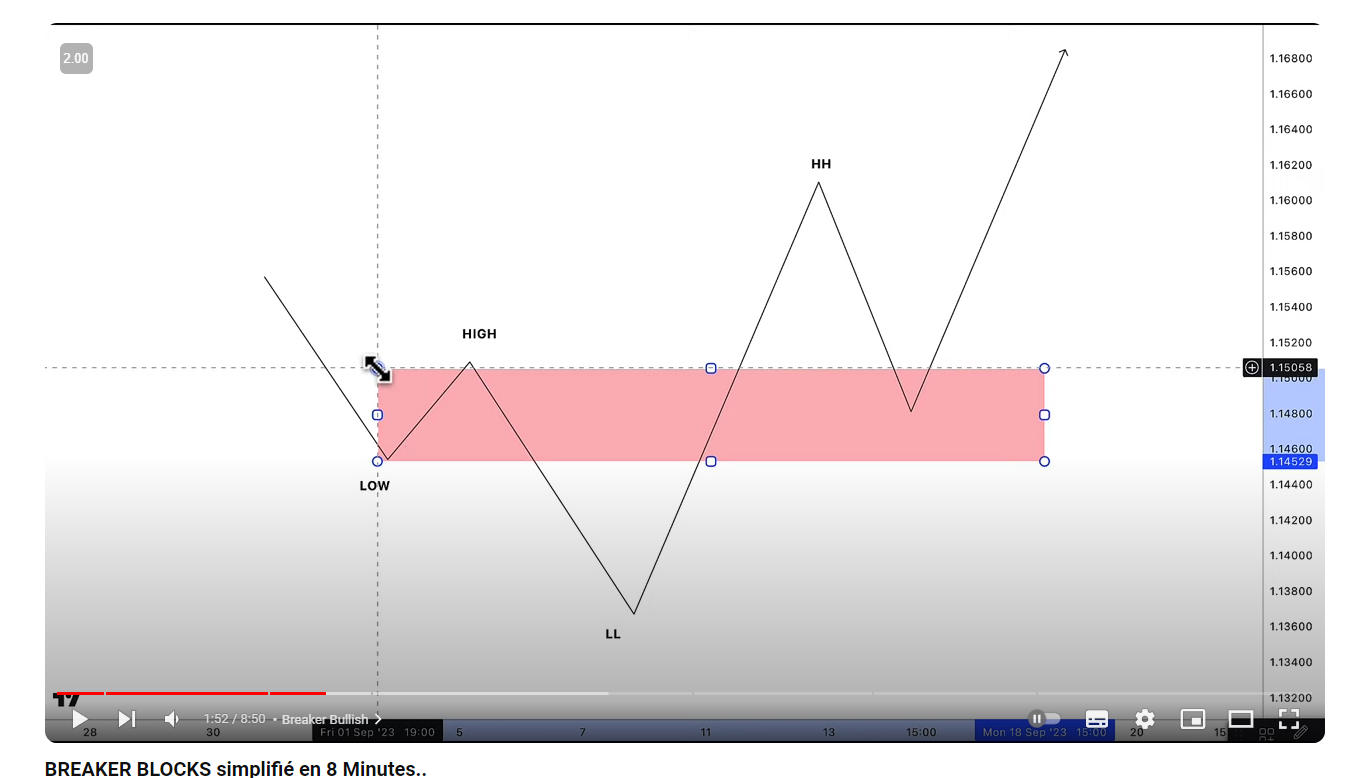
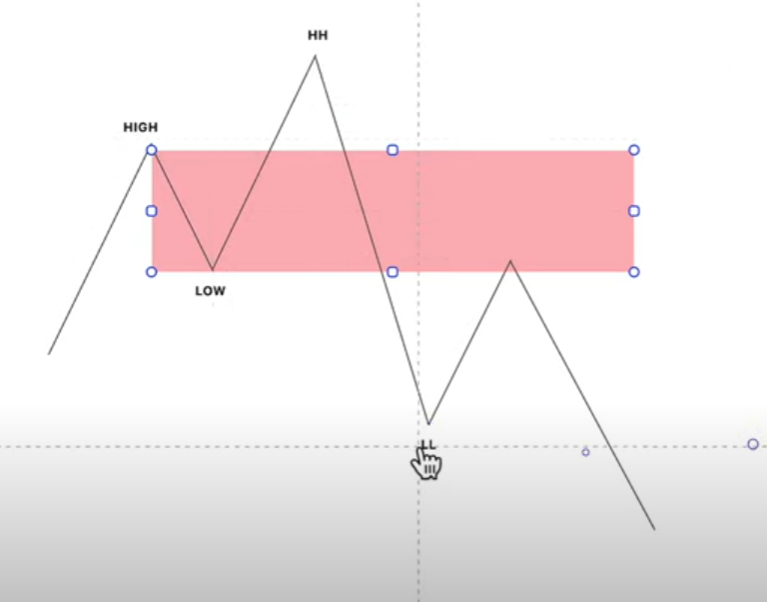

https://youtu.be/4G2YYt73mgo?t=396

# Importation des modules

In [94]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
from tqdm import tqdm
import matplotlib
matplotlib.use('TkAgg')

# Importation des datas

In [95]:
data = pd.read_csv('USDJPY_M15.csv')
data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(['date'])

In [96]:
data['ohlc4'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4 

In [97]:
data

,open,high,low,close,volume,ohlc4
date,,,,,,
2020-09-17 17:00:00,104.830,104.841,104.801,104.805,742,104.81925
2020-09-17 17:15:00,104.805,104.807,104.779,104.781,656,104.79300
2020-09-17 17:30:00,104.781,104.786,104.771,104.777,335,104.77875
2020-09-17 17:45:00,104.777,104.777,104.755,104.758,553,104.76675
2020-09-17 18:00:00,104.757,104.787,104.724,104.724,1203,104.74800
...,...,...,...,...,...,...
2024-09-19 15:45:00,142.941,142.974,142.867,142.883,4771,142.91625
2024-09-19 16:00:00,142.882,143.031,142.854,143.005,4610,142.94300
2024-09-19 16:15:00,143.004,143.035,142.886,142.937,3384,142.96550


# Détection des FVGs

In [98]:
# fvg calculation
window = 3
fvgs = np.zeros((len(data), 2))
last_fvg_up = data['ohlc4'].iloc[0]
last_fvg_down = data['ohlc4'].iloc[0]
fvgs[:window] = last_fvg_up
for i in tqdm(range(window, len(data)+1)):
    rows = data.iloc[i-window:i]
    if rows['open'].iloc[0] > rows['close'].iloc[2]:
        if rows['low'].iloc[0] > rows['high'].iloc[2]:
            last_fvg_up = rows['low'].iloc[0]
            last_fvg_down = rows['high'].iloc[2]
    if rows['open'].iloc[0] < rows['close'].iloc[2]:
        if rows['high'].iloc[0] < rows['low'].iloc[2]:
            last_fvg_up = rows['low'].iloc[2]
            last_fvg_down = rows['high'].iloc[0]

    fvgs[i-1, 0] = last_fvg_down
    fvgs[i-1, 1] = last_fvg_up

100%|██████████| 99997/99997 [00:21<00:00, 4676.99it/s]


# Détection des TOP/BOTTOM

In [99]:
neighborhoods = 20
window = neighborhoods * 2 + 1
last_top = data['ohlc4'].iloc[0]
last_bottom = data['ohlc4'].iloc[0]
top_bottom_df = []
index_top = []
index_bottom = []
for i in tqdm(range(window, len(data))):
    row = data.iloc[i - window:i]
    price = list(row['ohlc4'])
    midle_point = price.pop(-neighborhoods-1)
    if all(neighborhood < midle_point for neighborhood in price):
        last_top = midle_point
        index_top.append(i-1-neighborhoods)
    elif all(neighborhood > midle_point for neighborhood in price):
        last_bottom = midle_point
        index_bottom.append(i-1-neighborhoods)
    top_bottom_df.append([last_top, last_bottom]) 

100%|██████████| 99958/99958 [00:08<00:00, 11689.62it/s]


# Avec les TOP/BOTTOM on peut trouver nos breakers

In [100]:
dates_top = data['ohlc4'].index[index_top]
prices_top = data['ohlc4'].iloc[index_top].values  # Convertir en numpy array pour éviter les conflits d'index

dates_bottom = data['ohlc4'].index[index_bottom]
prices_bottom = data['ohlc4'].iloc[index_bottom].values  # Convertir en numpy array pour éviter les conflits d'index

# Créer des DataFrames pour les tops et bottoms
df_tops = pd.DataFrame({
    'date': dates_top,
    'price': prices_top,
    'type': 'top'
})

df_bottoms = pd.DataFrame({
    'date': dates_bottom,
    'price': prices_bottom,
    'type': 'bottom'
})

# Combiner et trier les points par date
df_points = pd.concat([df_tops, df_bottoms], ignore_index=True).sort_values('date').reset_index(drop=True)

# Créer le graphique
plt.figure(figsize=(14, 7))
plt.plot(data['ohlc4'].index, data['ohlc4'].values, label='Prix')

# Ajouter les points tops et bottoms
plt.scatter(df_tops['date'], df_tops['price'], color='green', marker='^', label='Tops')
plt.scatter(df_bottoms['date'], df_bottoms['price'], color='red', marker='v', label='Bottoms')

# Connecter les points en alternant entre tops et bottoms
for i in range(len(df_points) - 1):
    date_current = df_points.loc[i, 'date']
    price_current = df_points.loc[i, 'price']
    date_next = df_points.loc[i + 1, 'date']
    price_next = df_points.loc[i + 1, 'price']
    plt.plot([date_current, date_next], [price_current, price_next], color='black', linestyle='--')

plt.legend()
plt.title('Prix avec Tops et Bottoms Connectés')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.show()

In [101]:
# orderblock calculation
window_detection = 1000
df_window_points = df_points.set_index(['date']).reindex(data.index).shift(neighborhoods).ffill()

buy_breaker_block_low = data['ohlc4'].iloc[0]
buy_breaker_block_high = data['ohlc4'].iloc[0]
sell_breaker_block_low = data['ohlc4'].iloc[0]
sell_breaker_block_high = data['ohlc4'].iloc[0]
breaker_block_df = [[data['ohlc4'].iloc[0]] * 4] * window_detection
# Boucle sur la plage de données
for window in tqdm(range(window_detection, len(data))):
    # Extraction des données pour la fenêtre actuelle
    data_row = data.iloc[window - window_detection: window]
    row_points = df_window_points.iloc[window - window_detection: window]
    # Suppression des doublons basés sur 'price' et 'type'
    row_points = row_points.drop_duplicates(subset=['price', 'type'], keep='first')
    
    # Vérification si nous avons au moins 4 points
    if len(row_points) < 4:
        breaker_block_df.append([buy_breaker_block_low, buy_breaker_block_high, sell_breaker_block_low, sell_breaker_block_high])
        continue
    else:
        # Sélection des 4 derniers points
        last_points = row_points.copy().iloc[-4:]
        
        # Conditions pour le breaker block haussier
        bull_pattern_cond = (
            (last_points['type'].iloc[0] == 'bottom') and
            (last_points['type'].iloc[1] == 'top') and
            (last_points['type'].iloc[2] == 'bottom') and
            (last_points['type'].iloc[3] == 'top')
        )
        
        # Conditions pour le breaker block baissier
        bear_pattern_cond = (
            (last_points['type'].iloc[0] == 'top') and
            (last_points['type'].iloc[1] == 'bottom') and
            (last_points['type'].iloc[2] == 'top') and
            (last_points['type'].iloc[3] == 'bottom')
        )
        
        # Extraction des prix correspondants aux derniers points
        price_points = last_points['price'].reset_index(drop=True)
        
        # Détection du breaker block haussier
        if bull_pattern_cond:
            cond1buy = price_points.iloc[0] < price_points.iloc[1]
            cond2buy = price_points.iloc[2] < price_points.iloc[0]
            cond3buy = price_points.iloc[3] > price_points.iloc[1]
            total_cond_buy = cond1buy and cond2buy and cond3buy
            if total_cond_buy:
                buy_breaker_block_low = price_points.iloc[0]
                buy_breaker_block_high = price_points.iloc[1]
        
        # Détection du breaker block baissier
        if bear_pattern_cond:
            cond1sell = price_points.iloc[0] > price_points.iloc[1]
            cond2sell = price_points.iloc[2] > price_points.iloc[0]
            cond3sell = price_points.iloc[3] < price_points.iloc[1]
            total_cond_sell = cond1sell and cond2sell and cond3sell
            if total_cond_sell:
                sell_breaker_block_high = price_points.iloc[0]
                sell_breaker_block_low = price_points.iloc[1]
    
    # Ajout des résultats à la liste
    breaker_block_df.append([
        buy_breaker_block_low, 
        buy_breaker_block_high, 
        sell_breaker_block_low, 
        sell_breaker_block_high
    ])

100%|██████████| 98999/98999 [01:56<00:00, 849.26it/s] 


In [102]:
data[['fvg_down', 'fvg_up']] = fvgs
data[['buy_breaker_block_low', 'buy_breaker_block_high', 'sell_breaker_block_low', 'sell_breaker_block_high']] = np.array(breaker_block_df)

In [103]:
data[['buy_breaker_block_low', 'buy_breaker_block_high', 'sell_breaker_block_low', 'sell_breaker_block_high']]

,buy_breaker_block_low,buy_breaker_block_high,sell_breaker_block_low,sell_breaker_block_high
date,,,,
2020-09-17 17:00:00,104.81925,104.81925,104.81925,104.81925
2020-09-17 17:15:00,104.81925,104.81925,104.81925,104.81925
2020-09-17 17:30:00,104.81925,104.81925,104.81925,104.81925
2020-09-17 17:45:00,104.81925,104.81925,104.81925,104.81925
2020-09-17 18:00:00,104.81925,104.81925,104.81925,104.81925
...,...,...,...,...
2024-09-19 15:45:00,140.45250,140.93550,144.31075,144.59775
2024-09-19 16:00:00,140.45250,140.93550,144.31075,144.59775
2024-09-19 16:15:00,140.45250,140.93550,144.31075,144.59775


In [104]:
size = 2000
range_rand = int(np.random.uniform(low=0, high=len(data)-size))
sample = data.iloc[range_rand:range_rand+size]

In [105]:
df_bottoms_sample = df_bottoms[(df_bottoms['date'] >= sample.index.min()) & (df_bottoms['date'] <= sample.index.max())]
df_tops_sample = df_tops[(df_tops['date'] >= sample.index.min()) & (df_tops['date'] <= sample.index.max())]
df_points_sample = df_points[(df_points['date'] >= sample.index.min()) & (df_points['date'] <= sample.index.max())]

In [106]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

# Ajouter le chandelier en utilisant un axe catégoriel
fig.add_trace(go.Candlestick(
    x=sample.index,  # Utilisation des dates sous forme d'index (axe catégoriel)
    open=sample['open'],
    high=sample['high'],
    low=sample['low'],
    close=sample['close'],
    name='Chandelier'
))

# Ajouter les bandes de Bollinger
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['fvg_down'],
    line=dict(color='blue', width=1),
    name='fvg Bande inférieure',
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['fvg_up'],
    line=dict(color='blue', width=1),
    fill='tonexty',  # Remplir entre les bandes
    name='fvg Bande supérieure',
    mode='lines'
))

# Ajouter les Breaker Blocks haussiers (Bullish)
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['buy_breaker_block_low'],
    line=dict(color='green', width=1),
    name='BB Bullish Bas',
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['buy_breaker_block_high'],
    line=dict(color='green', width=1),
    fill='tonexty',  # Remplir entre les bandes
    name='BB Bullish Haut',
    mode='lines'
))

# Ajouter les Breaker Blocks baissiers (Bearish)
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['sell_breaker_block_low'],
    line=dict(color='red', width=1),
    name='BB Bearish Bas',
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['sell_breaker_block_high'],
    line=dict(color='red', width=1),
    fill='tonexty',  # Remplir entre les bandes
    name='BB Bearish Haut',
    mode='lines'
))

# Ajouter les points tops
fig.add_trace(go.Scatter(
    x=df_tops_sample['date'],
    y=df_tops_sample['price'],
    mode='markers',
    marker=dict(symbol='triangle-up', color='green', size=10),
    name='Tops'
))

# Ajouter les points bottoms
fig.add_trace(go.Scatter(
    x=df_bottoms_sample['date'],
    y=df_bottoms_sample['price'],
    mode='markers',
    marker=dict(symbol='triangle-down', color='red', size=10),
    name='Bottoms'
))

# Connecter les points tops et bottoms avec des lignes noires
fig.add_trace(go.Scatter(
    x=df_points_sample['date'],
    y=df_points_sample['price'],
    mode='lines',
    line=dict(color='black', dash='dash'),
    name='Lignes de connexion'
))

# Mettre en forme le graphique
fig.update_layout(
    title='Graphique Chandelier avec Tops et Bottoms Connectés',
    xaxis_title='Date',
    yaxis_title='Prix',
    xaxis_rangeslider_visible=False,  # Cacher le slider par défaut
    xaxis_type='category',  # Configurer l'axe des X en catégoriel
    template='plotly_white'
)

# Afficher le graphique dans une nouvelle fenêtre de navigateur
pio.renderers.default = "browser"
fig.show()

# Logique du backtest

# ⚠️ Avertissement

Lorsque vous réduisez le **stop loss** vers zéro dans votre stratégie de trading, cela peut entraîner des résultats **irréalistes** et potentiellement dangereux :

- **Take Profit et Stop Loss au niveau du prix d'entrée :**
  - Avec un stop loss proche de zéro, le stop loss et le take profit sont pratiquement égaux au **prix d'entrée**.
  - De **minuscules fluctuations** du marché peuvent déclencher le take profit, donnant l'illusion de gains faciles.

- **PNL artificiellement élevé :**
  - Les petits gains répétés sans pertes apparentes peuvent s'accumuler, créant un **PNL total énorme**.
  - Cela **ne reflète pas la réalité** des conditions du marché et peut conduire à une **fausse confiance** dans la stratégie.

- **Absence de trades perdants :**
  - Un stop loss à zéro signifie que le stop loss n'est **presque jamais déclenché**, éliminant les pertes dans la simulation.
  - Cela **biaisera** vos résultats et vous empêchera d'évaluer correctement les risques.

- **Ignoration des coûts de transaction :**
  - Les **frais**, le **slippage** et le **spread** ne sont pas pris en compte, ce qui est crucial pour une stratégie avec une fréquence de trading élevée.
  - Ces coûts peuvent **annuler les petits gains** réalisés sur chaque trade.

## **Recommandations :**

- **Ne pas définir le stop loss à zéro :**
  - Fixez un stop loss minimal réaliste (par exemple, **0,5% ou 1%**) pour refléter les conditions du marché.

- **Inclure les coûts de transaction :**
  - Intégrez les **frais de trading**, le **slippage** et le **spread** dans votre simulation pour des résultats plus précis.

- **Limiter la fréquence des trades :**
  - Évitez d'entrer et de sortir de positions sur des **fluctuations de prix insignifiantes**.

- **Vérifier les données utilisées :**
  - Assurez-vous que vos données de prix sont **précises et granulaires** pour éviter des déclenchements irréalistes du stop loss ou du take profit.

---

**Attention :** Ignorer ces points peut conduire à une **mauvaise évaluation des risques** et à des **pertes financières importantes** lors de l'application de la stratégie en conditions réelles.

In [114]:
in_pos = None
stop_loss = 0.005
rr = 4
strat_logs = []

for index, row in data.iterrows():
    if in_pos == 'long':
        if row.ohlc4 <= actual_stop:
            # Stop loss atteint
            exit_price = actual_stop
            exit_time = index
            pnl = exit_price - entry_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
        elif row.ohlc4 >= take_profit:
            # Take profit atteint
            exit_price = take_profit
            exit_time = index
            pnl = exit_price - entry_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
    elif in_pos == 'short':
        if row.ohlc4 >= actual_stop:
            # Stop loss atteint
            exit_price = actual_stop
            exit_time = index
            pnl = entry_price - exit_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
        elif row.ohlc4 <= take_profit:
            # Take profit atteint
            exit_price = take_profit
            exit_time = index
            pnl = entry_price - exit_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
    else:
        # Pas en position
        if row.ohlc4 > row.fvg_down and row.ohlc4 < row.fvg_up:
            if row.ohlc4 > row.buy_breaker_block_low and row.ohlc4 < row.buy_breaker_block_high:
                # Entrée en position longue
                in_pos = 'long'
                entry_price = row.ohlc4
                actual_stop = entry_price * (1 - stop_loss)
                stop_distance = entry_price - actual_stop
                take_profit = entry_price + stop_distance * rr
                entry_time = index
            elif row.ohlc4 > row.sell_breaker_block_low and row.ohlc4 < row.sell_breaker_block_high:
                # Entrée en position courte
                in_pos = 'short'
                entry_price = row.ohlc4
                actual_stop = entry_price * (1 + stop_loss)
                stop_distance = actual_stop - entry_price
                take_profit = entry_price - stop_distance * rr
                entry_time = index

strat_logs = pd.DataFrame(strat_logs, columns=['exit_price', 'entry_price', 'type', 'entry_time', 'exit_time', 'pnl'])

In [115]:
plt.title("USDJPY / SL 0.5% / RR 4")
strat_logs['pnl'].cumsum().plot(figsize=(12,8))
plt.xlabel("Nombre de Trades")
plt.ylabel("PnL")
plt.savefig("USDJPY SL 0.5% RR 4.png")
plt.show()

In [81]:
strat_logs.tail(50)

,exit_price,entry_price,type,entry_time,exit_time,pnl
838,1.085511,1.085403,short,2024-05-27 13:30:00,2024-05-27 13:45:00,-0.000109
839,1.085966,1.086075,long,2024-05-27 16:45:00,2024-05-27 17:00:00,-0.000109
840,1.085884,1.085993,long,2024-05-28 19:30:00,2024-05-28 20:30:00,-0.000109
841,1.085659,1.085767,long,2024-05-28 21:15:00,2024-05-28 22:30:00,-0.000109
842,1.085449,1.085340,short,2024-06-03 02:30:00,2024-06-03 03:00:00,-0.000109
843,1.084693,1.085453,short,2024-06-03 03:15:00,2024-06-03 07:45:00,0.000760
844,1.087226,1.086465,long,2024-06-04 12:00:00,2024-06-04 14:45:00,0.000761
845,1.087368,1.086608,long,2024-06-05 11:45:00,2024-06-05 12:15:00,0.000761
846,1.073248,1.073355,long,2024-06-24 22:45:00,2024-06-24 23:00:00,-0.000107
847,1.074349,1.073597,long,2024-06-30 22:45:00,2024-07-01 00:30:00,0.000752


In [25]:
plt.style.use('seaborn-darkgrid')

# Convertir les index en format datetime
data.index = pd.to_datetime(data.index)
strat_logs['entry_time'] = pd.to_datetime(strat_logs['entry_time'])
strat_logs['exit_time'] = pd.to_datetime(strat_logs['exit_time'])

# Créer un index numérique pour les données
data['index_num'] = range(len(data))
index_mapping = pd.Series(data.index, index=data['index_num'])

# Mapper les temps d'entrée et de sortie sur l'index numérique
strat_logs['entry_index'] = strat_logs['entry_time'].map(data.reset_index().set_index('date')['index_num'])
strat_logs['exit_index'] = strat_logs['exit_time'].map(data.reset_index().set_index('date')['index_num'])

# Préparer le graphique
plt.figure(figsize=(15, 7))

# Tracer le prix ohlc4
plt.plot(data['index_num'], data['ohlc4'], label='Prix OHLC4', color='#1f77b4', linewidth=1.5)

# Ajouter les spreads des FVG
plt.fill_between(data['index_num'], data['fvg_down'], data['fvg_up'], color='#ff7f0e', alpha=0.3, label='FVG')

# Ajouter les spreads des buy order blocks
plt.fill_between(data['index_num'], data['buy_breaker_block_low'], data['buy_breaker_block_high'], color='#2ca02c', alpha=0.4, label='Buy Order Block')

# Ajouter les spreads des sell order blocks
plt.fill_between(data['index_num'], data['sell_breaker_block_low'], data['sell_breaker_block_high'], color='#d62728', alpha=0.4, label='Sell Order Block')

# Marquer les positions longues
long_trades = strat_logs[strat_logs['type'] == 'long']
plt.scatter(long_trades['entry_index'], long_trades['entry_price'], marker='^', color='#17becf', label='Entrée Longue', s=200)
plt.scatter(long_trades['exit_index'], long_trades['exit_price'], marker='v', color='#e377c2', label='Sortie Longue', s=200)

# Marquer les positions courtes
short_trades = strat_logs[strat_logs['type'] == 'short']
plt.scatter(short_trades['entry_index'], short_trades['entry_price'], marker='v', color='#bcbd22', label='Entrée Courte', s=200)
plt.scatter(short_trades['exit_index'], short_trades['exit_price'], marker='^', color='#7f7f7f', label='Sortie Courte', s=200)

# Ajuster l'axe des x pour afficher les dates sans gaps
plt.xticks(data['index_num'][::int(len(data)/10)], data.index.strftime('%Y-%m-%d')[::int(len(data)/10)], rotation=45)

# Ajouter des labels et une légende
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix', fontsize=12)
plt.title('Positions de Trading avec FVG et Order Blocks', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ftiag\AppData\Local\Temp\ipykernel_13604\2260884127.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

